# Download and Create Landsat 8 dataset using rasterio

The Landsat 8 satellite orbits the the Earth in a sun-synchronous, near-polar orbit, at an altitude of 705 km (438 mi) and circles the Earth every 99 minutes.  The satellite has a 16-day repeat cycle with an equatorial crossing time: 10:00 a.m. +/- 15 minutes.  

Landsat 8 data are acquired on the Worldwide Reference System-2 (WRS-2) path/row system. The day time path and row for San Diego is - 40, 37

The scene size for landsat 8 is 170 km x 185 km (106 mi x 115 mi). 



In [1]:
import os
import json
import rasterio
import requests
import matplotlib.pyplot as plt
import numpy as np


## Data source

Landsat 8 images are available in Registry of opendata in AWS ( https://registry.opendata.aws/landsat-8/ ). 

The data are organized using a directory structure based on each scene’s path and row. For instance, the files for Landsat scene LC08_L1TP_139045_20170304_20170316_01_T1 are available in the following location: s3://landsat-pds/c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/

The “c1” refers to Collection 1, the “L8” refers to Landsat 8, “139” refers to the scene’s path, “045” refers to the scene’s row, and the final directory matches the product’s identifier, which uses the following naming convention: LXSS_LLLL_PPPRRR_YYYYMMDD_yyymmdd_CC_TX, in which:

L = Landsat
X = Sensor
SS = Satellite
PPP = WRS path
RRR = WRS row
YYYYMMDD = Acquisition date
yyyymmdd = Processing date
CC = Collection number
TX = Collection category
In this case, the scene corresponds to WRS path 139, WRS row 045, and was taken on March 4th, 2017.

An example directory will be: https://landsat-pds.s3.amazonaws.com/c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/index.html

Inside each directory, GeoTiff images of different band are available and also the metadata in .txt format. 

The Landsat 8 bands are:

| Band                                  |
|---------------------------------------|
| Band 1 - coastal aerosol              |
| Band 2 - blue                         |
| Band 3 - green                        |
| Band 4 - red                          |
| Band 5 - Near Infrared (NIR)          |
| Band 6 - Short-wave Infrared (SWIR) 1 |
| Band 7 - Short-wave Infrared (SWIR) 2 |
| Band 8 - Panchromatic                 |
| Band 9 - Cirrus                       |
| Band 10 - TIRS 1                      |
| Band 11 - TIRS 2                      |


The entire scene list (URLS to all directories of all paths and rows) is available at http://landsat-pds.s3.amazonaws.com/scene_list.gz or s3://landsat-pds/scene_list.gz. The structure of csv is :


| id   | productId                                | entityId              | acquisitionDate            | cloudCover | processingLevel | path | row | min_lat  | min_lon             | max_lat  | max_lon             | download_url                                                                                                     |   |
|------|------------------------------------------|-----------------------|----------------------------|------------|-----------------|------|-----|----------|---------------------|----------|---------------------|------------------------------------------------------------------------------------------------------------------|---|
| 4916 | LC08_L1TP_040037_20170330_20170414_01_T1 | LC80400372017089LGN00 | 2017-03-30 18:22:08.295500 | 17.73      | L1TP            | 40   | 37  | 32.10751 | -118.42548000000001 | 34.22299 | -115.94958999999999 | https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/040/037/LC08_L1TP_040037_20170330_20170414_01_T1/index.html |   |

We can filter the above csv by path and row to get only the San Diego scenes.


Given below are the TIFF files of Red and NIR bands for one scene. Let us download them and process them using rasterio.

In [2]:
red_filename = 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/040/037/LC08_L1TP_040037_20170415_20170501_01_T1/LC08_L1TP_040037_20170415_20170501_01_T1_B4.TIF'
nir_filename = 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/040/037/LC08_L1TP_040037_20170415_20170501_01_T1/LC08_L1TP_040037_20170415_20170501_01_T1_B5.TIF'

In [3]:
def download_file(in_filename, out_filename):
    if not os.path.exists(out_filename):
        print("Downloading", in_filename)
        response = requests.get(in_filename)
        with open(out_filename, 'wb') as f:
            f.write(response.content)


In [4]:
download_file(red_filename, 'data/red.tif')
download_file(nir_filename, 'data/nir.tif')


## Process images using rasterio - Study the data

Let us open the two images we downloaded, usin rasterio. The returned object is a **DatasetReader** object. It holds a lot of meta data related to the image. Some of the parameters provide good insights to the task in hand.

### Tiled
Is the data tiled? 

In [5]:
# Reference - https://rasterio.readthedocs.io/en/stable/quickstart.html
reader_red = rasterio.open('data/red.tif')
print(reader_red.is_tiled)

reader_nir = rasterio.open('data/nir.tif')
print(reader_nir.is_tiled)

True
True


### How many Bands are there in the image?

In [6]:
reader_red.count

1

We downloaded the red band. The count confirms that the image has only one band in it.

### What is the  size of each block (tile itself, as per my understanding) ?

In [7]:
reader_red.block_shapes

[(512, 512)]

Image has many blocks with each block having size 512 x 512
### What is the size of the band image?

In [8]:
print(reader_red .width)
print(reader_red.height)


7691
7821


The dataset reader profile will give all these details in a comprehensive dict of values.

In [9]:
reader_red.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7691, 'height': 7821, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 367785.0,
       0.0, -30.0, 3787815.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

## The bounding box

The bounds option will show the spatial reference. Every pixel in the raster image is inside a rectangular bounding box in the world. The landsat image below covers the world from 367785 meters to 598515 meters left to right and 3787815.0 meters to 3553185 meters top to bottom. This covers 230.73km x 234.63km.

![See the image](https://lh3.googleusercontent.com/A_eiJG9oeGnyrypCgwsLfpoNCrXOyvXERN_SKO9W6WopdmZee7RqRr661AMCUl0tQ1jbUVBBD6C6ZgIONneAzM8A3avMTAduODTlVi3_XOf9mLGpNxJC0FQJBxvoBJUtIZPthq7xb7TWFIkLfK_re-Ag3NcjlovgtZSrRV_wjBOhOVotg11eKFIB2M5o5_B7MIBojTMbip5gw-tiOaSryFdIzgYjH8QVFImUZgqNlHm1EjRNU8tc9FIhHb-4L2z7t8_ULN-RveOHwTMXkv7Vp2vBEq55C1NnguwkTChK2ad9q1KQIeEN6UnbgVJf3-4XJF7Z8gAjpltlRTX9VfEpIMB65R0UuQH9z--UZv8RKJwxWfiFEKRTRyipMZyx6tA81iNUNaSxtF5ABJ4y99sVj1FZtVi-lfg4vz8WSqj6UKo8tDcM3VcXm8PerwVT5lQiE_2CS8cDH23PZt2W_LruoyxuEa39chUbK0mZny4FEi8ejWMlGVQONaPgpfr0AlQNs1a0aFaILp-XBUGjtARpHTTaqMczUmzGhqhbbeF7q4F4W8tmOm111GledwfGbq7atsIBP3rYP4AMvUZ1vflaGhxJX6WWwV1ReNSl4ZXU2lXLePsLrYKZ1Zrvw7O9Ci7cW6HaHkivWfXyHn7T7fy24oYsRZDs0PVUaHm1A8Fg7tETjTh5DnDQBPI=w928-h740-no)

In [10]:
reader_red.bounds

BoundingBox(left=367785.0, bottom=3553185.0, right=598515.0, top=3787815.0)

The above bounds can also be derived from an affine transform matrix, as shown below. An affine transformation preserves the collinearity between two points and ratios of distances. It doesn't preserve the angles though. ( Refer - http://mathworld.wolfram.com/AffineTransformation.html ).


In [11]:
reader_red.transform

Affine(30.0, 0.0, 367785.0,
       0.0, -30.0, 3787815.0)

This matrix can be used to find the mapping between pixel position in the image and (x,y) coordinate on the ground. Simply multiply the pizel position by the affine matrix. For example, 
the top,left corner of the bounding box can be calculated by multiplying the transformatiom matrix with (0,0)

In [12]:
reader_red.transform * (0, 0)

(367785.0, 3787815.0)

In [13]:
#Find the (x,y) coordinate of bottm right corner
reader_red.transform * (reader_red.width, reader_red.height)

(598515.0, 3553185.0)

What is the reference point from which these meters are measured? The answer is CRS - coordinate reference system. Our file uses EPSG for the coordinate reference. 

In [14]:
reader_red.crs

CRS.from_epsg(32611)

EPSG 32611 is band in North America. See the pic. 

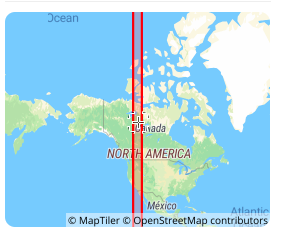

Knowing the coordinate reference system and values helps us to translate the positions to different formats and location specifications like (row, column), (latitude, longitude) etc.

From the rasterio documentation:
"“EPSG 32612” identifies a particular coordinate reference system: UTM zone 12N. This system is used for mapping
areas in the Northern Hemisphere between 108 and 114 degrees west. The upper left corner of the example dataset,
(358485.0, 4265115.0), is 141.5 kilometers west of zone 12’s central meridian (111 degrees west) and 4265
kilometers north of the equator"

In [15]:
#import xarray as xr
#red = xr.open_rasterio('data/red.tif', chunks={'band': 1, 'x': 512, 'y': 512})
#red = xr.open_rasterio('data/red.tif', chunks={'band': 1, 'x': 1024, 'y': 1024})
#nir = xr.open_rasterio('data/nir.tif', chunks={'band': 1, 'x': 1024, 'y': 1024})
#print(red)
#print(red.variable.data)

In [16]:
red = reader_red.read(1) # 1 is the band number. 
#If there were more than one band, they could be accessed by changing the number.
nir = reader_nir.read(1)

## spatial coordinates to row-column and vice versa

For this, let us go back to the bounding box. Use the top, left, right, bottom attributes along with 
offsets to specify the geospatial coordinate for a point. Then, use index() method to convert this coordinate to the row and column of the raster data matrix, as shown:


In [17]:
x, y = (reader_red.bounds.left + 100000, reader_red.bounds.top - 50000)
row, col = reader_red.index(x, y)
print(row, col)
red[row, col]

1666 3333


13118

In reverse, to convert one (row, column) of the raster matrix to the geospatial(x,y), call the xy() function.

In [18]:
row, col = (0,0) #very first pixel in the image.
x, y = reader_red.xy(row, col)
x,y

(367800.0, 3787800.0)

## Visualizing

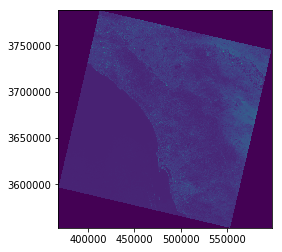

In [19]:
from rasterio.plot import show # import the show function which allows us to display the image

#print("Image dimensions: ", img.shape)
show(red, transform=reader_red.transform)

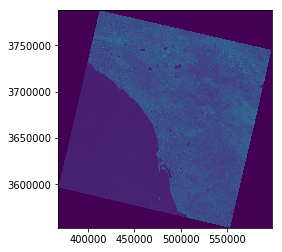

In [20]:
show(nir, transform=reader_nir.transform)

## Calculate NDVI using NIR and Red Bands

In [21]:
ndvi = (nir.astype(float) - red.astype(float)) / (nir.astype(float) + red.astype(float))
#ndvi=np.where((nir+red) == 0, 0, (nir.astype(float) - red.astype(float)) / (nir.astype(float) + red.astype(float))
#)

/Users/nasrajan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/nasrajan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


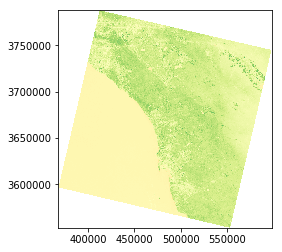

In [22]:
show(ndvi, transform=reader_red.transform, cmap='RdYlGn')

## NDVI After Atmospheric correction

Let us try calculating NDVI after removing the atmospheric reflection.

In [25]:
def load_scale_factors(filename, band_number):
    with open(filename) as f:
        data = f.read()
        #print(data)
        # metadata = json.dump(data)
        ''' M_p = metadata['L1_METADATA_FILE'] \
                  ['RADIOMETRIC_RESCALING'] \
                  ['REFLECTANCE_MULT_BAND_{}'.format(band_number)]
            A_p = metadata['L1_METADATA_FILE'] \
                  ['RADIOMETRIC_RESCALING'] \
                  ['REFLECTANCE_ADD_BAND_{}'.format(band_number)]
         '''
        #hard cording the above values from the meta data file for now
        M_p = 2.0000E-05
        A_p = -0.100000
    return M_p, A_p
def calculate_reflectance(ds, band_number, metafile='data/LC08_L1TP_040037_20170415_20170501_01_T1_MTL.txt'):
    M_p, A_p = load_scale_factors(metafile, band_number)
    toa = M_p * ds + A_p
    return toa


In [26]:
red_toa = calculate_reflectance(red, band_number=4)
nir_toa = calculate_reflectance(nir, band_number=5)


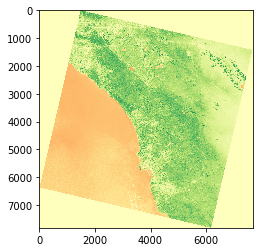

In [27]:
#Calculate NDVI Again
ndvi = (nir_toa - red_toa) / (nir_toa + red_toa)
#ndvi2d = ndvi.squeeze()
plt.figure()
#im = ndvi2d.compute().plot.imshow( vmin=-1, vmax=1,cmap='RdYlGn')
plt.imshow(ndvi, vmin=-1, vmax=1, cmap='RdYlGn')
#plt.axis('equal')
#plt.show()


As we already discussed, the above scene covers an area of 230.73km x 234.63km on the ground. This is pretty large for most of the studies. So, we can create small windows which cover a smaller area, out of the entire scene. Landsat 8 rasters have their own blocks defined. We can utilize this natural division to find the windows.  The Dataset reader's *block_shapes* property tells us the block sizes. As we have alreayd examined, for our data, the block size is (512,512). We can define the starting coordinate position using pixel values and define the window. See my scratch paper:
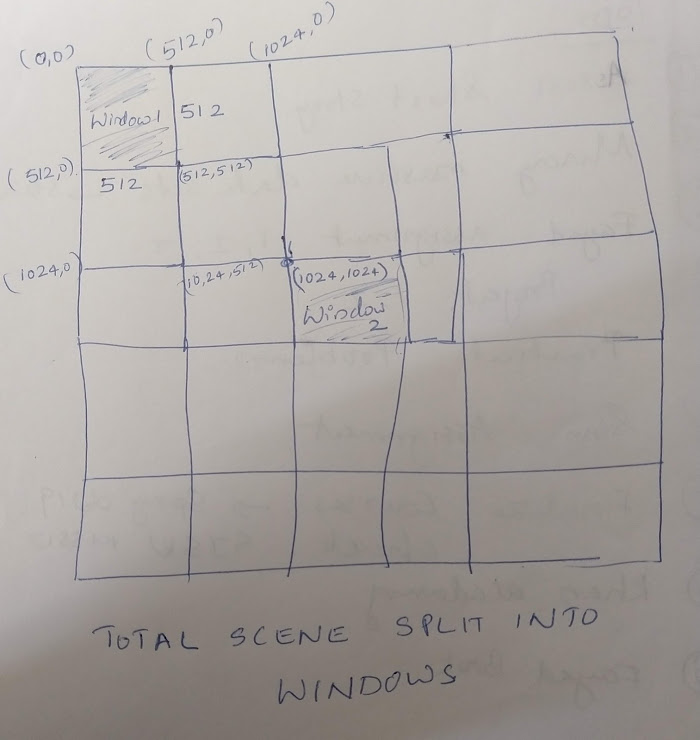

We are going to plot those shaded windows in the scratch paper.
See those example windows from the red band image we have downloaded above.




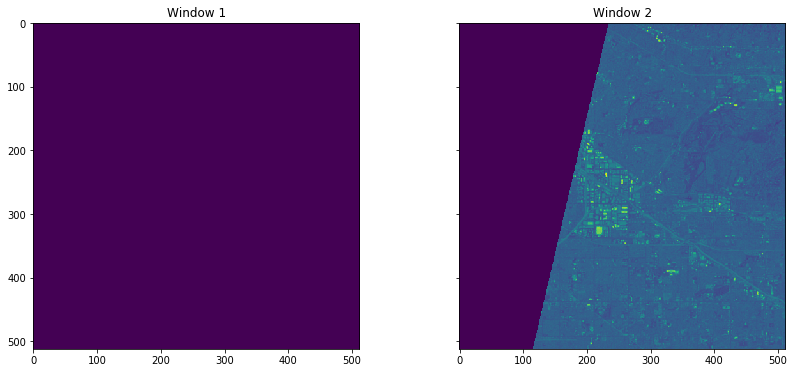

In [88]:
from rasterio import windows
fig, axes = plt.subplots(1,2, figsize=(14,6), sharex=True, sharey=True)

xoff, yoff = 0, 0
width, height = 512, 512
subset = reader_red.read(1, window=windows.Window(xoff, yoff, width, height))
plt.sca(axes[0])
plt.title("Window 1")
plt.imshow(subset)

xoff, yoff = 1024, 1024
width, height = 512, 512
subset = reader_red.read(1, window=windows.Window(xoff, yoff, width, height))
plt.sca(axes[1])
plt.title("Window 2")
plt.imshow(subset)


Remembering that our scene image dimensions are 7691 x 7821, one block size is 512 x 512, the area covered by the entire raster image on the ground  is 230.73km x 234.63km - The area covered by the window above will be 14km x 14 km roughly. 

By iterating through  through block_windows function, we can retrieve all the defined blocks.

In [103]:
for ji, window in reader_red.block_windows(1):
        subset = reader_red.read(1, window=windows.Window(window.col_off, window.row_off, 
                                                          window.width, window.height))
        
        if(ji[0] == 14 & ji[0] == 15):
            plt.imshow(subset)
            break
      


   

In [ ]:
#write ndvi as a raster file
